# Analytics of ML features Usage in IDEs

In [5]:
import pandas as pd
import plotly.express as px
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from collections import defaultdict

### Data overview

In [6]:
df = pd.read_csv('da_internship_task_dataset.csv')
print(f'Zero count: {(df==0).sum().to_dict()}')
print(f'NaN count:\n{df.isna().sum().to_dict()}\n')
print(df[['requests_cnt', 'spent_amount']].describe().T)

for col in ['license', 'model', 'feature']:
    print(f'\n{col} types: {df[col].unique()}')

Zero count: {'uuid': 0, 'day_id': 0, 'license': 0, 'model': 0, 'feature': 0, 'requests_cnt': 0, 'spent_amount': 0}
NaN count:
{'uuid': 0, 'day_id': 0, 'license': 0, 'model': 0, 'feature': 0, 'requests_cnt': 0, 'spent_amount': 0}

                 count       mean         std   min    25%    50%    75%  \
requests_cnt  122746.0  51.260742  167.977380  1.00  18.00  32.00  54.00   
spent_amount  122746.0  12.227798   37.588494  0.27   5.14   8.02  13.06   

                  max  
requests_cnt  12900.0  
spent_amount   2599.0  

license types: ['Premium' 'Basic' 'Enterprise' 'Standard']

model types: ['Model_A' 'Model_B' 'Model_D' 'Model_E' 'Model_C']

feature types: ['Feature_1' 'Feature_2' 'Feature_3' 'Feature_5' 'Feature_4']


### Categorical features relationships

Create new feature of average amounts spent on requests to better compare configurations of models-features-licenses

In [7]:
summary = df.groupby(['model', 'license', 'feature'], as_index=False).agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
})
summary['price_per_req'] = summary['spent_amount'] / summary['requests_cnt']
summary.head(2)

,model,license,feature,requests_cnt,spent_amount,price_per_req
0,Model_A,Basic,Feature_1,68852.0,25056.26,0.363915
1,Model_A,Basic,Feature_2,52306.0,19357.27,0.370077


Visualize requests to each model with respect to license types

In [8]:
fig_req_bar = px.bar(summary.groupby(['model', 'license'], as_index=False)
                    .agg({'requests_cnt':'sum', 'spent_amount':'sum'}),
             x='model', y='requests_cnt', color='license',
             hover_data={'spent_amount': ':.2f'},
             title='Total requests per model by license type')
fig_req_bar.show()

From the barchart above, we can see that models C and D are the most popular ones among all users, they are getting almost double the number of requests compared to the rest. Each license type contributes a decent share across models, but Premium and Enterprise users make up a big part of total activity. Interesting to note that the Premium license customers seem to make more requests to model C, while the Standard license users prefer model D with a similar total amount of requests. The other 3 models are not that extensively used, why could that be?

In [9]:
model_prices = summary.groupby('model', as_index=False)['price_per_req'].mean()
print(model_prices)

     model  price_per_req
0  Model_A       0.368739
1  Model_B       0.364160
2  Model_C       0.190119
3  Model_D       0.190664
4  Model_E       0.190265


From the table it is clear that models A and B are twice as expensive per request than the other 3. This could partially explain why they are used less. However, model E costs like C and D, yet receives fewer requests. This suggests that other factors other than price could be the case.

In [10]:
user_counts = df.groupby('model')['uuid'].nunique().reset_index(name='unique_users').sort_values('unique_users', ascending=False)
print(user_counts)

     model  unique_users
0  Model_A           843
3  Model_D           705
2  Model_C           644
1  Model_B           610
4  Model_E           441


Turns out model E is used less at least by 5.2% fewer total users than any other model. In this case, the around 730 thousand requests shows that people who use it are quite active. Some customers might want to utilize multiple models. Let's plot the intersections of top 3 used models.

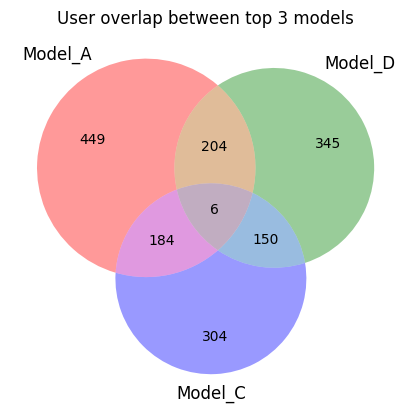

In [11]:
top3 = user_counts['model'].head(3).tolist()
user_sets = {m: set(df[df['model'] == m]['uuid']) for m in top3}

venn3([user_sets[top3[0]], user_sets[top3[1]], user_sets[top3[2]]],
      set_labels=top3)
plt.title('User overlap between top 3 models')
plt.show()

Models A and D have the largest user groups, while model C overlaps more with others. Only 6 users worked with all three, indicating limited cross-model experimentation. This shows that each model serves a somewhat distinct user segment, with A and D being primary choices, and the model C being a runner-up. But what all of them are actually used for?

In [12]:
pivot = summary.pivot_table(values='requests_cnt', index='feature', columns='model', aggfunc='sum', fill_value=0)
fig = px.imshow(pivot, text_auto=True, color_continuous_scale='YlGnBu',
                title='Feature usage by model', labels={'color': 'requests'})
fig.show()

The heatmap shows how request volume is distributed across features for each model.
- Features 1 and 2 clearly prevail across all models, so they are likely the core functionalities to work with LLMs in IDEs.
- Models C and D dominate most features, matching their overall earlier discovered high usage.
- Model B's usage of feature 4 is by far the lowest in the map, which may indicate that this model is not well-suited or not frequently chosen for that functionality.
- The smoother gradient across model E's features can point that it serves a niche role, because features 4 and 5 are used more extensively, proportionally compared to other models.


These points suggest that models C and D act as main general-purpose engines, model A exhibits similarly but is twice as costly. Model E could focus on specialized features, and model B also could be a niche one, as 50% of total requests to it were made by Enterprise users (from the barchart in 1st plot).

Now we check how features usage differs across licenses

In [13]:
license_feature = df.groupby(['license', 'feature'], as_index=False).agg({
    'requests_cnt':'sum', 'spent_amount':'sum'
})
fig = px.bar(license_feature, x='feature', y='requests_cnt', color='license',
             barmode='group',
             title='Feature usage by license type')
fig.show()

In [14]:
license_users = (
    df.groupby('license')['uuid']
      .nunique()
      .reset_index(name='unique_users')
      .sort_values('unique_users', ascending=False)
)
print(license_users)

      license  unique_users
0       Basic           717
3    Standard           708
1  Enterprise           251
2     Premium           247


Although Basic and Standard licenses represent almost 75% of all users, their contribution to number of features requests is much smaller. Enterprise and Premium users still generate the majority of requests. The Enterprise license users lead in total usage of all features, which is explained by organisations distributing licenses within teams. This highlights higher engagement rate among top-tier licenses, though raises a slight possibility of usage capping.

In [28]:
max_spend_per_license = (
    df.groupby(['license', 'uuid', 'day_id'], as_index=False)['spent_amount']
      .sum()  # sum if a user has multiple records that day
      .groupby('license')['spent_amount']
      .max()
      .reset_index(name='max_single_day_spent')
      .sort_values('max_single_day_spent', ascending=False)
)
print(max_spend_per_license)

      license  max_single_day_spent
1  Enterprise                4039.5
2     Premium                3337.0
3    Standard                2172.5
0       Basic                1055.5


While there is a clear upward trend, the differences are not sharp enough to indicate hard capping. Instead, they reflect gradual scaling of credit budget. Enterprise and Premium users spend more because of higher activity, which is expected when the customers are companies and developers.

In [16]:
fig = px.sunburst(summary, path=['license', 'model', 'feature'],
                  values='spent_amount',
                  color='license',
                  title='Spending breakdown by License - Model - Feature')
fig.show()

This sunburst summarizes spending on models. It looks almost symmetrical with a slight underusage of basic license. Overall, it confirms previously discovered patterns that: models C and D are most used and monetized, features 1 and 2 are most represented - could be core LLM functionalities for development like code generation/completion, Enterprise and Premium tiers contribute the largest share of total gain.

### Temporal trends

Let's find out about usage patterns over time

In [17]:
# get time periods
df['day_id'] = pd.to_datetime(df['day_id'])
df['week'] = df['day_id'].dt.isocalendar().week
df['month'] = df['day_id'].dt.month
daily = df.groupby('day_id', as_index=False).agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
})

weekly = df.groupby('week', as_index=False).agg({
    'requests_cnt': 'sum',
    'spent_amount': 'sum'
})

In [18]:
fig = px.line(
    daily,
    x='day_id',
    y='requests_cnt',
    title='Daily total requests in March-May 2025',
    labels={'day_id': 'Date', 'requests_cnt': 'Total requests'}
)
fig.update_traces(line=dict(width=2))
fig.update_layout(height=400)
fig.show()

The line plot of daily total requests has many peaks and dips, where peaks plateau for roughly 5 days, and the usage of LLMs drops on weekends. This suggests that many users employ LLMs for work, and around 20% customers include them in development on weekends. Let's now look into weekly results to check the long-term growth pattern.

In [19]:
fig_week = px.line(
    weekly,
    x='week',
    y='requests_cnt',
    title='Weekly total requests in March-May 2025',
    labels={'week': 'Week', 'requests_cnt': 'Total requests'}
)
fig_week.update_traces(line=dict(width=2))
fig_week.update_layout(height=400)
fig_week.show()

The graph shows a clear upward trajectory. Weeks 9-13 exhibit steady growth, followed by a dip in week 14, dropping by 25% of requests compared to week 13. This could mean that a feature version was retrained, leading to reduced availability. Overall, the usage increased by ~46.5% (from 374k to 548k requests) within 3 months, which shows expansion of LLM-powered IDE features adoption and growth of users' activity. The steady post-dip recovery could align with behavior dynamics: users become more active. Could that be because of upgrading licenses and exploring more advanced features?

In [20]:
license_changes = (
    df.groupby('uuid')['license']
      .nunique()
      .reset_index(name='license_count')
)

# filter users with >1 license
switchers = license_changes[license_changes['license_count'] > 1]
print(f'Users who changed license: {len(switchers)}/{df['uuid'].nunique()}')

Users who changed license: 57/1866


3% of users switched their license. We want to understand, whether it was upgrade, why and when it happened.

In [21]:
df_sorted = df.sort_values(['uuid', 'day_id']).drop_duplicates(['uuid', 'day_id'])
user_switch_timestamps = defaultdict(list)

for user, group in df_sorted.groupby('uuid'):
    group = group[['day_id', 'license']].sort_values('day_id').reset_index(drop=True)

    # compare each license with previous
    for i in range(1, len(group)):
        prev_license = group.loc[i-1, 'license']
        curr_license = group.loc[i, 'license']
        if prev_license != curr_license:
            switch_date = group.loc[i, 'day_id']
            user_switch_timestamps[user].append({
                'from': prev_license,
                'to': curr_license,
                'switch_date': switch_date
            })

for user, switches in list(user_switch_timestamps.items())[2:5]:
    print(f"\nUser: {user}")
    for s in switches:
        print(f"  {s['from']} -> {s['to']}  on {s['switch_date'].date()}")


User: user_1110
  Basic -> Standard  on 2025-05-28
  Standard -> Basic  on 2025-05-29

User: user_1111
  Standard -> Basic  on 2025-03-16
  Basic -> Standard  on 2025-03-17
  Standard -> Basic  on 2025-03-22
  Basic -> Standard  on 2025-03-24
  Standard -> Basic  on 2025-04-04
  Basic -> Standard  on 2025-04-05
  Standard -> Basic  on 2025-04-06
  Basic -> Standard  on 2025-04-07
  Standard -> Basic  on 2025-04-13
  Basic -> Standard  on 2025-04-14
  Standard -> Basic  on 2025-05-08
  Basic -> Standard  on 2025-05-09
  Standard -> Basic  on 2025-05-17
  Basic -> Standard  on 2025-05-18
  Standard -> Basic  on 2025-05-30

User: user_1113
  Standard -> Basic  on 2025-04-07
  Basic -> Standard  on 2025-04-11
  Standard -> Basic  on 2025-04-13
  Basic -> Standard  on 2025-04-14
  Standard -> Basic  on 2025-04-20
  Basic -> Standard  on 2025-04-22
  Standard -> Basic  on 2025-04-27
  Basic -> Standard  on 2025-04-28
  Standard -> Basic  on 2025-05-07
  Basic -> Standard  on 2025-05-08
  St

For many switcher users, the licenses are updated quite regularly. The first thought was usage of LightEdit mode, thus the license goes to basic for quick changes, but the LightMode does not support the usual IDE editor features such as code completion. It could be logging noise or automated activity.

In [22]:
# consistency = active days / total days in dataset
active_days = df.groupby('uuid')['day_id'].nunique()
consistency = (active_days / df['day_id'].nunique()).reset_index(name='activity_ratio')
fig_active_days = px.histogram(consistency, x='activity_ratio', nbins=40, title='User activity consistency ratio', height=400)
fig_active_days.update_layout(xaxis_title='Fraction of active days', yaxis_title='Number of users')
fig_active_days.show()

The distribution above shows how active users are during the whole time period. Score of 1.0 means that the models were used every day, which is not the case for any user. Most users exploited the features for about 1.5 month from March to May 2025. But how long are users engaged during this period?

In [23]:
df['first_week'] = df.groupby('uuid')['week'].transform('min')
cohort = df.groupby(['first_week', 'week'])['uuid'].nunique().reset_index()

cohort_size = cohort.groupby('first_week')['uuid'].transform('first')
cohort['retention'] = cohort['uuid'] / cohort_size

fig_cohort = px.line(cohort, x='week', y='retention', color='first_week',
              title='User retention by cohort week',
              labels={'retention':'Retention rate'})
fig_cohort.show()

In this case, I call cohort a group of users who began (not really, just appeared in dataset for the first time) using the product in the same period - first active week. By tracking each cohort's activity in later weeks, user retention can be evaluated. This metric helps to distinguish short-term curiosity from real engagement.
From the plot:
- Early cohorts (weeks 9-10) maintain high retention, staying above 0.9. Most users stayed active during this period. And further assumption is that they used the models consistently before March 2025.
- Later cohorts show sharper drops, indicating users who joined later were less engaged.
- Most later cohorts have a couple of spikes, which means they might still be experimenting with the product.
- Week 14 is interesting because of a sudden drop and lowest retention of 53%, which can also be confirmed by curves of daily and weekly activities.


Overall, the retention remained above 60%, meaning that new customers continued to return and actively use LLM-powered features throughout the 3-month period. Together with the consistency ratio results, this indicates that most users stay active for about 1.5 months on average, while early adopters demonstrate stronger, long-term engagement patterns and are more likely to integrate these features into their regular development workflow.

Let's dig a little bit deeper into less active week 14.

In [24]:
weeks_focus = [13, 14, 15]

weekly_model = df.groupby(['week', 'model'])['requests_cnt'].sum().reset_index()
weekly_license = df.groupby(['week', 'license'])['requests_cnt'].sum().reset_index()

weekly_model = weekly_model[weekly_model['week'].isin(weeks_focus)]
weekly_license = weekly_license[weekly_license['week'].isin(weeks_focus)]

def week_change(df, col):
    pivot = df.pivot(index=col, columns='week', values='requests_cnt').fillna(0)
    pivot['14-13 %_change'] = ((pivot[14] - pivot[13]) / pivot[13]) * 100
    pivot = pivot.round(2)
    return pivot.sort_values('14-13 %_change')

print("\nChange of requests by model")
print(week_change(weekly_model, 'model'))

print("\nChange of requests by license")
print(week_change(weekly_license, 'license'))


Change of requests by model
week           13       14        15  14-13 %_change
model                                               
Model_E   58366.0  34246.0   57068.0          -41.33
Model_B   46713.0  32868.0   53853.0          -29.64
Model_A   61218.0  43463.0   78264.0          -29.00
Model_D  122870.0  98447.0  165419.0          -19.88
Model_C  107214.0  90561.0  142403.0          -15.53

Change of requests by license
week              13       14        15  14-13 %_change
license                                                
Enterprise  139818.0  88922.0  152872.0          -36.40
Premium      95178.0  66301.0  135762.0          -30.34
Basic        72693.0  52664.0   81585.0          -27.55
Standard     88692.0  91698.0  126788.0            3.39


Across models and licenses week 14 shows a significant decline in total requests, followed by recovery in week 15. The sharpest drop occurred for model E (-41% compared to week 13), while more widely used models C and D were more in demand (-15% and -19%). Since all models' usage grew in week 15, the dip likely reflects a system-wide slowdown or retraining period, not loss of user interest. On the contrary, during the maintenance the features were likely improved, and more users started testing them.

Three out of 4 licenses were negatively affected, while Standard tier gained 3% of requests. This could be because the license absorbed part of demand during the disruption, serving as a fallback for continued usage, as the Standard license has more users than the top-tier ones.


Overall, week 14 is likely a service adjustment, not a behavioral change. It acted as a catalyst for next week growth, in which users could interact with models more efficiently.

### Key findings

In [25]:
user_activity = df.groupby('uuid')['requests_cnt'].sum().sort_values(ascending=False).reset_index()

user_activity['cumulative_requests'] = user_activity['requests_cnt'].cumsum()
user_activity['cumulative_share'] = user_activity['cumulative_requests'] / user_activity['requests_cnt'].sum()
user_activity['user_rank'] = range(1, len(user_activity) + 1)
user_activity['user_percentile'] = user_activity['user_rank'] / len(user_activity) * 100

pareto_threshold = user_activity[user_activity['cumulative_share'] <= 0.8]['user_percentile'].max()
fig = px.line(
    user_activity,
    x='user_percentile',
    y='cumulative_share',
    title='Pareto principle applied to user activity',
    labels={'user_percentile': 'Users (percentile)', 'cumulative_share': 'Cumulative share of requests'}
)

fig.add_hline(y=0.8, line_dash='dash', line_color='red',
              annotation_text='80% threshold', annotation_position='top left')

fig.add_vline(x=pareto_threshold, line_dash='dash', line_color='green',
              annotation_text=f'Top {pareto_threshold:.1f}% users', annotation_position='bottom right')

fig.update_layout(height=400)
fig.show()

The user population deviates from the classical principle: top 37.8% of users contribute 80% of total requests. This shows that while highly-active users remain key customers, a relatively larger share of users also consistently employ the features. How could we make them join the top 38%?

In [26]:
total_users = df.groupby('uuid')['spent_amount'].sum().sort_values(ascending=False)
cum_share = total_users.cumsum() / total_users.sum()
top_users = cum_share[cum_share <= 0.8].index

top_df = df[df['uuid'].isin(top_users)]

model_license_spent = (
    top_df.groupby(['model','license'])['spent_amount']
          .sum()
          .reset_index(name='total_spent_sum')
          .sort_values('total_spent_sum', ascending=False)
)

fig_tree = px.treemap(
    model_license_spent,
    path=['license','model'],
    values='total_spent_sum',
    title='Top-38% users by spending: model–license distribution',
    color='total_spent_sum',
    color_continuous_scale='fall',
    hover_data={
        'total_spent_sum': ':.2f'
    },
    height=450
)
fig_tree.show()

Expectedly, top two licenses that give the most spent profit are Enterprise and Premium. Enterprise members employ models A, D, C, B in similar proportion with A and B being notably more expensive per request. This pattern suggests that the customers rely on these models for high-stakes workloads. This also explains a peak in their activity after presumably maintenance week 14. In this context, the higher costs of A and B are justified by performance, as enterprises prioritize stability and latency over credit efficiency.

Premium users, on the other hand, spend more on model C. The runner-up is model A. This might indicate single developers or small teams working on advanced but localized development tasks. These users are the target audience most likely to upgrade when given access to higher-tier features or with time as they might deploy a heavier workload.

Standard users form 2nd largest mid-tier segment after Basic license users. They rely on models C and D, which seem to be general-purpose and lower-cost models that still deliver strong performance according to total requests plots. The users' behavior shows consistent but moderate engagement, suggesting they could benefit most from targeted features or usage-based discounts that will encourage scaling up.

Finally, Basic users contribute the smallest amount, primarily using C and D. Their engagement is not much smaller proportionally than of those with higher tiers, and the total number of users during Spring 2025 period is the biggest among all license types. The Basic tier can be then considered an entry point for casual users, who might just play around (which is good and should be encouraged). But this could imply limited functionality. Nonetheless, this tier plays an important role in onboarding and later switching to higher tiers. The activity patterns mirror the overall usage drop observed in week 14, implying that the Basic users were affected by limited model availability. Once the models were restored, the usage rose, meaning the demand for improved baseline features is high, even among free or limited-in-features users. Adjusting these entry-level capabilities could help retain those users longer and offer them other licenses over time.

Altogether, this distribution reveals a clear tiered ecosystem: Enterprise and Premium users drive revenue through high-intensity, performance-critical workloads, while Standard and Basic tiers serve as entry and midpoints in the upgrade path  &ndash; essential for sustaining long-term platform adoption.

#### Final summary

The analysis of ML feature usage in IDEs over March–May 2025 reveals a clear trajectory of growth.

- **Adoption trends:** overall activity increased by nearly 50% within three months, showing that LLM-powered functionalities are becoming integral to daily development workflows fast. Despite a temporary dip in week 14 (likely due to maintenance) usage grew, suggesting feature improvement and stable user interest.
- **Spending concentration:** around 38% of users account for 80% of all spending, with Enterprise and Premium tiers driving most revenue. These segments rely heavily on high-performance models (A and B), while Standard and Basic licenses mainly use general-purpose, lower-cost ones (C and D). The balanced distribution has both a core of power users and an active mid-tier base with upgrade potential.
- **Upgrade behavior:** about 3% of users switched licenses during the period. While some changes may reflect automated activity, overall engagement patterns suggest that exposure to advanced features motivates transitions upward. Even Basic users affected by downtime in week 14 resumed activity once models stabilized, indicating demand across all tiers.

**In conclusion**, expanding access to advanced models and improving entry-level functionality could further enhance user retention and conversion across license types.